# Semantic Segmentation

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torchsummary import summary
import gc
import os
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore', category=Warning)

torch.manual_seed(42) 
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>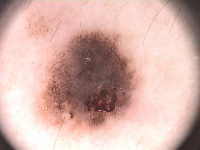</td><td>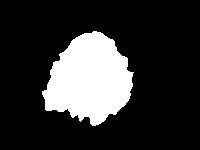</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [2]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
get_ipython().system_raw("unrar x PH2Dataset.rar")

--2020-05-29 20:43:48--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-05-29 20:43:48--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc4e6ba0d429630ab59448a2c83.dl.dropboxusercontent.com/cd/0/inline/A4qHOg3BkNN48qOjMvLBRXzgQ4E3UIf1x3HubCpO1i6UhH_Va3vEqfsK6OWwOrLIp_UGiyV_YFYadIgowMOjKc3mhPhl51fUf3E9tZd8XEVa9A/file# [following]
--2020-05-29 20:43:49--  https://ucc4e6ba0d429630ab59448a2c83.dl.dropboxusercontent.com/cd/0/inline/A4qHOg3BkNN48qOjMvLBRXzgQ4E3UIf1x3HubCpO1i6UhH_Va3vEqfsK6OWwOrLIp_UGiyV_YFYadIgowMOjKc3mhPhl51fUf3E9tZd8XEVa9A/file
Resolving 

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))
len(lesions)

200

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

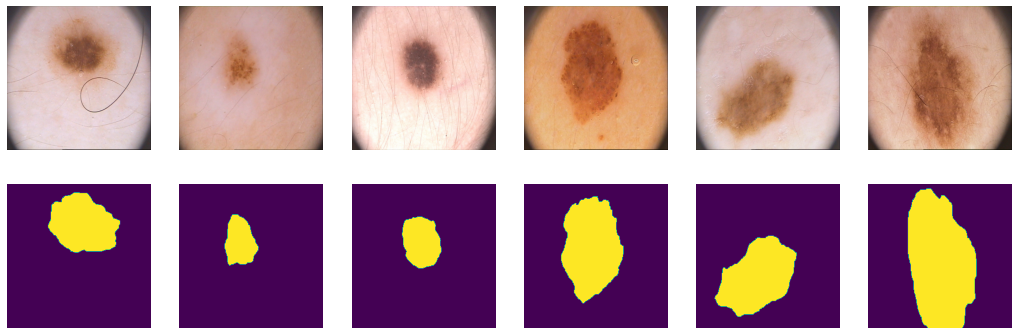

In [6]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [7]:
np.random.seed(42)
ix = np.random.randint(0, len(X), len(X))
tr, val, ts = np.split(ix, [100, 150])
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [0]:
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [10]:
gc.collect()
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
!nvidia-smi


cuda
Fri May 29 20:44:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  

In [0]:
losses = []

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

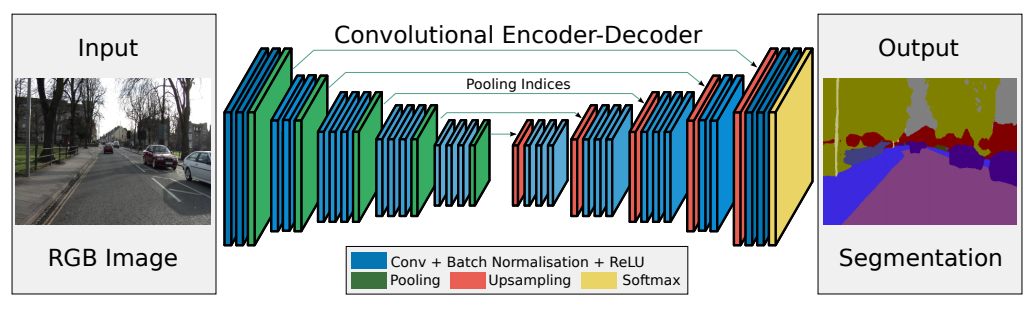

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.bne0 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128

        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.bne1 = nn.BatchNorm2d(64)
        self.pool1 =  nn.MaxPool2d(2) # 128 -> 64

        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bne2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2) # 64 -> 32

        self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bne3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, 3, padding=1)
        self.bnbn = nn.BatchNorm2d(256)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bicubic') # 16 -> 32
        self.dec_conv0 = nn.Conv2d(256, 128, 3, padding=1)
        self.bnd0 = nn.BatchNorm2d(128)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bicubic')  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.bnd1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bicubic')  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.bnd2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bicubic')  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bne0(self.enc_conv0(x.cuda()))))
        e1 = self.pool1(F.relu(self.bne1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bne2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bne3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bnbn(self.bottleneck_conv(e3)))

        # decoder
        d0 = F.relu(self.bnd0(self.dec_conv0(self.upsample0(b))))
        d1 = F.relu(self.bnd1(self.dec_conv1(self.upsample1(d0))))
        d2 = F.relu(self.bnd2(self.dec_conv2(self.upsample2(d1))))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [0]:
class SegNet_2(nn.Module): # Version with MaxPool indexing.
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.bne0 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.bne1 = nn.BatchNorm2d(64)
        self.pool1 =  nn.MaxPool2d(2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bne2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bne3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, 3, padding=1)
        self.bnbn = nn.BatchNorm2d(256)

        # decoder (upsampling)
        self.unpool0 = nn.MaxUnpool2d(2) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(256, 128, 3, padding=1)
        self.bnd0 = nn.BatchNorm2d(128)

        self.unpool1 = nn.MaxUnpool2d(2)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.bnd1 = nn.BatchNorm2d(64)

        self.unpool2 = nn.MaxUnpool2d(2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.bnd2 = nn.BatchNorm2d(32)

        self.unpool3 = nn.MaxUnpool2d(2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0, pi0 = self.pool0(F.relu(self.bne0(self.enc_conv0(x.cuda()))))
        e1, pi1 = self.pool1(F.relu(self.bne1(self.enc_conv1(e0))))
        e2, pi2 = self.pool2(F.relu(self.bne2(self.enc_conv2(e1))))
        e3, pi3 = self.pool3(F.relu(self.bne3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bnbn(self.bottleneck_conv(e3)))

        # decoder
        d0 = F.relu(self.bnd0(self.dec_conv0(self.unpool0(b, pi3))))
        d1 = F.relu(self.bnd1(self.dec_conv1(self.unpool1(d0, pi2))))
        d2 = F.relu(self.bnd2(self.dec_conv2(self.unpool2(d1, pi1))))
        d3 = self.dec_conv3(self.unpool3(d2, pi0))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_real, y_pred):

    y_pred = y_pred.cpu()
    bceloss = y_pred - y_real*y_pred+torch.log(1+torch.exp(-y_pred))
    return torch.mean(bceloss)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    train_loss = []
    val_loss = []
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch.to(device)
            # set parameter gradients to zero
            model.zero_grad()
            
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss = loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            loss = loss_fn(Y_batch, Y_pred)
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss) # show intermediate results

        model.eval()  # testing mode
        X_val.to(device)
        Y_hat = model(X_val) 
        # detach and put into cpu
        loss_val = loss_fn(Y_val, Y_hat)
        print('val_loss: %f' % loss_val)

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 8))
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow((Y_hat.cpu().detach()>0)[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(np.rollaxis(Y_val[k].numpy(), 0, 3).reshape(256,256))
            plt.title('Real_segm')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

        train_loss.append(avg_loss.detach().numpy())
        val_loss.append(loss_val.detach().numpy())
    
    losses.append((train_loss, val_loss))
    return train_loss, val_loss

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        # Y_pred = predict(model, X_batch.to(device))
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred>0, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

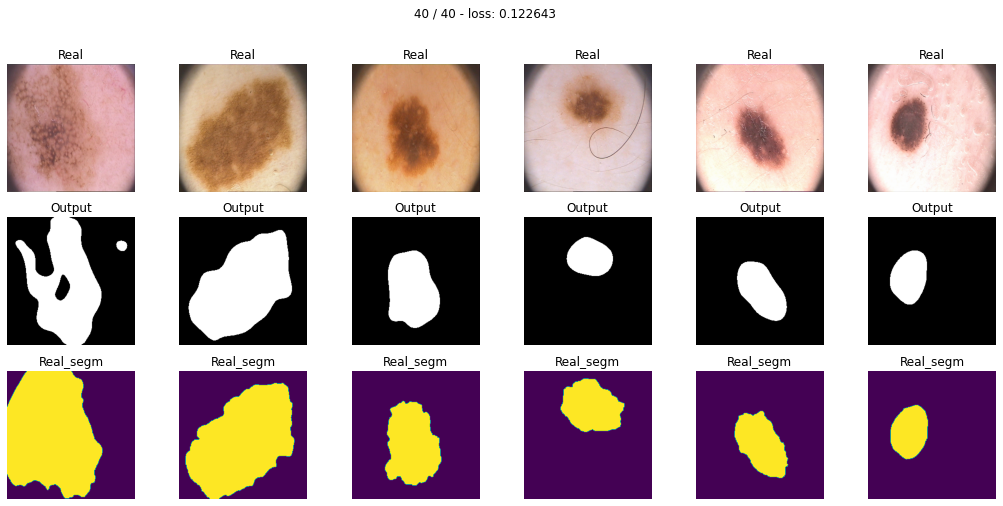

SegNet (BCE loss), IoU score on test data: 0.668


In [18]:
model_s = SegNet().to(device)
max_epochs = 40

optimaizer = torch.optim.Adam(model_s.parameters(), lr=0.001)
train_loss_s, val_loss_s = train(model_s, optimaizer, bce_loss, max_epochs, data_tr, data_val)
sb_score = np.round(score_model(model_s, iou_pytorch, data_ts), 4)
print("SegNet (BCE loss), IoU score on test data: {}".format(sb_score))

SegNet (BCE loss), IoU score on test data: 0.668


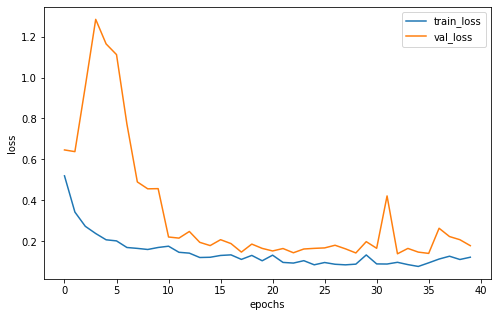

In [19]:
print("SegNet (BCE loss), IoU score on test data: {}".format(sb_score))
plt.figure(figsize=(8,5))
plt.plot(train_loss_s, label="train_loss")
plt.plot(val_loss_s, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss");

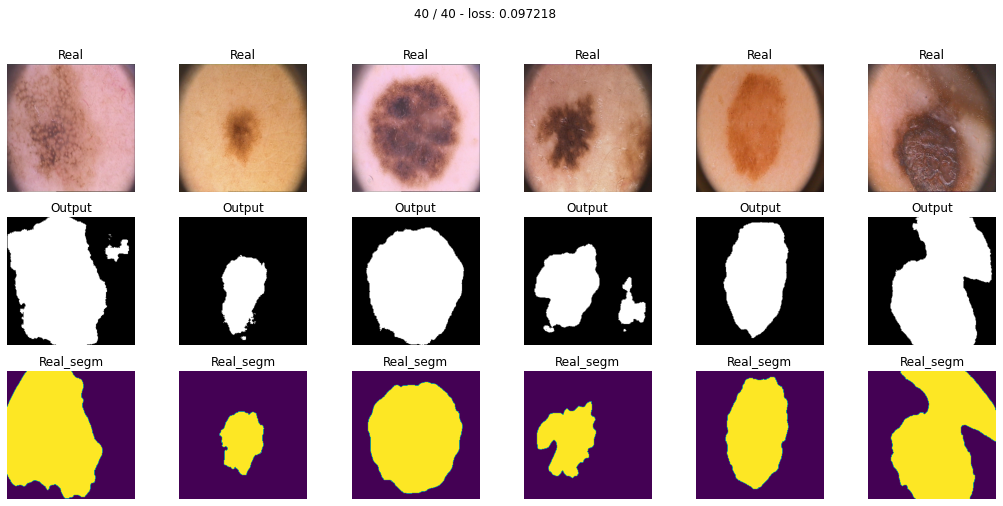

SegNet (BCE Loss), IoU score on test data: 0.708


In [22]:
model_s2 = SegNet_2().to(device) # Segnet version with indexing and unpooling

max_epochs = 40
optimaizer = torch.optim.Adam(model_s2.parameters(), lr=0.001)
train_loss_s2, val_loss_s2 = train(model_s2, optimaizer, bce_loss, max_epochs, data_tr, data_val)
s2b_score = np.round(score_model(model_s2, iou_pytorch, data_ts), 4)
print("SegNet2 (BCE loss), IoU score on test data: {}".format(s2b_score))

SegNet2 (BCE loss), IoU score on test data: 0.708


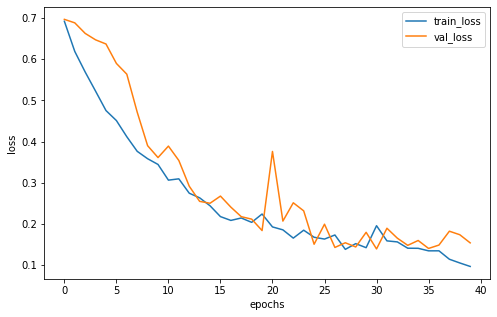

In [23]:
print("SegNet2 (BCE loss), IoU score on test data: {}".format(s2b_score))
plt.figure(figsize=(8,5))
plt.plot(train_loss_s2, label="train_loss")
plt.plot(val_loss_s2, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss");

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_real, y_pred):
    smooth=1
    y_pred = F.sigmoid(y_pred).cpu()
    num = (2*y_real*y_pred).sum()+smooth
    den = (y_real+y_pred).sum()+smooth
    res = 1 - (num/den)
    return res 

Проводим тестирование:

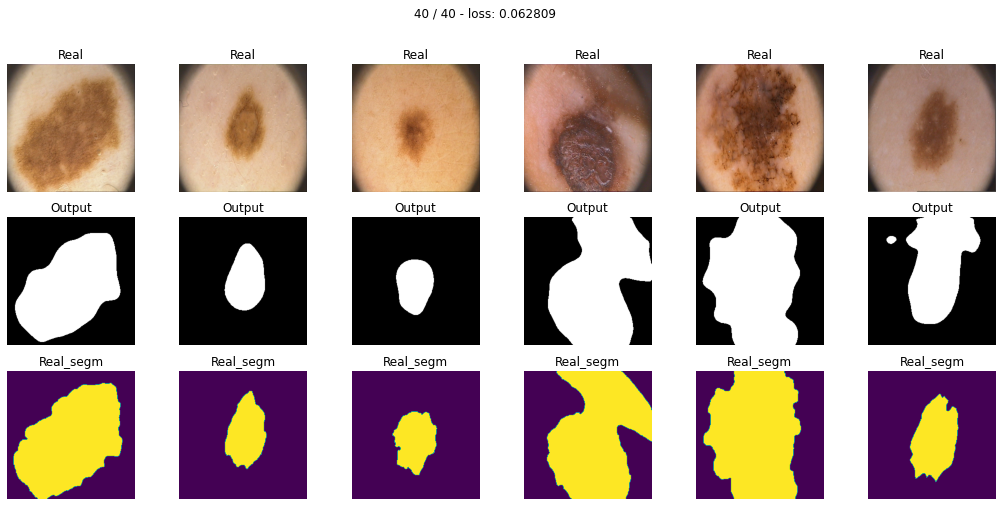

SegNet (DICE loss), IoU score on test data: 0.706


In [25]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=0.001)
train_loss_sd, val_loss_sd = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)
sd_score = np.round(score_model(model_dice, iou_pytorch, data_ts), 4)
print("SegNet (DICE loss), IoU score on test data: {}".format(sd_score))

SegNet (DICE loss), IoU score on test data: 0.706


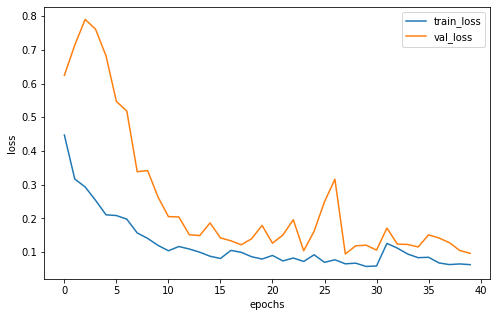

In [26]:
print("SegNet (DICE loss), IoU score on test data: {}".format(sd_score))
plt.figure(figsize=(8,5))
plt.plot(train_loss_sd, label="train_loss")
plt.plot(val_loss_sd, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss");

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [0]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = F.sigmoid(y_pred).cpu()
    focal_loss = - ((1 - y_pred)**gamma*y_real*torch.log(y_pred) + (1 - y_real)*torch.log(1 - y_pred))
    return torch.mean(focal_loss)

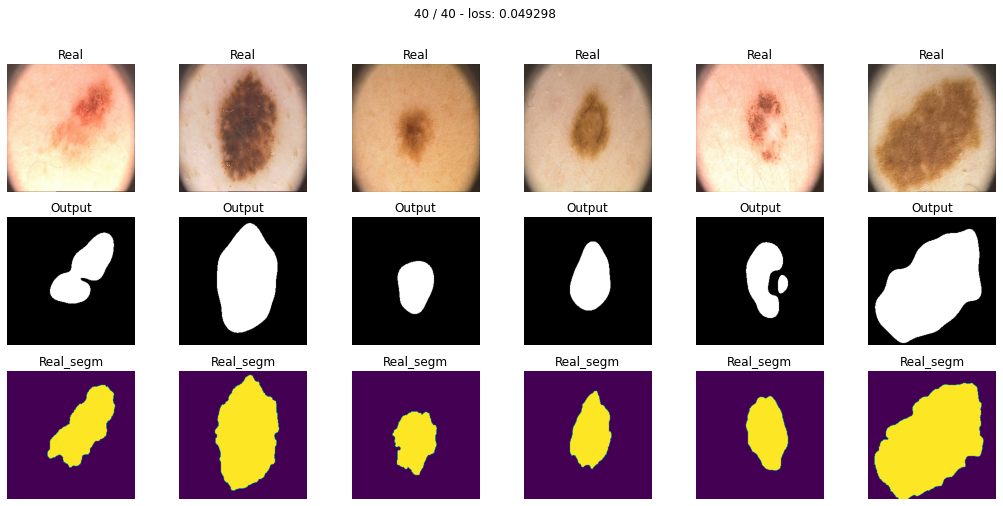

SegNet (Focal loss), IoU score on test data: 0.716


In [28]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters(), lr = 0.001)
train_loss_sf, val_loss_sf = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)
sf_score = np.round(score_model(model_focal, iou_pytorch, data_ts), 4)
print("SegNet (Focal loss), IoU score on test data: {}".format(sf_score))

SegNet (Focal loss), IoU score on test data: 0.716


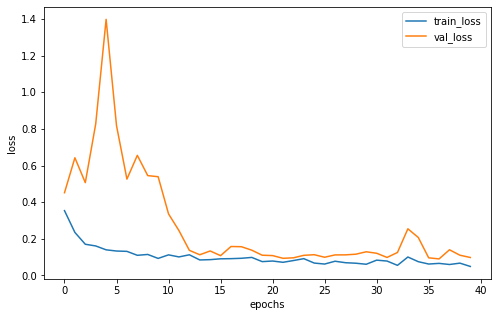

In [29]:
print("SegNet (Focal loss), IoU score on test data: {}".format(sf_score))
plt.figure(figsize=(8,5))
plt.plot(train_loss_sf, label="train_loss")
plt.plot(val_loss_sf, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss");

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [0]:
def tversky_loss(y_real, y_pred, beta=0.5):
  y_pred = F.sigmoid(y_pred).cpu()
  numerator = (y_real * y_pred).sum()
  denominator = (y_real * y_pred + beta * (1 - y_real) * y_pred + (1 - beta) * y_real * (1 - y_pred)).sum()

  tversky_loss = 1 - (numerator + 1) / (denominator + 1)
  return tversky_loss

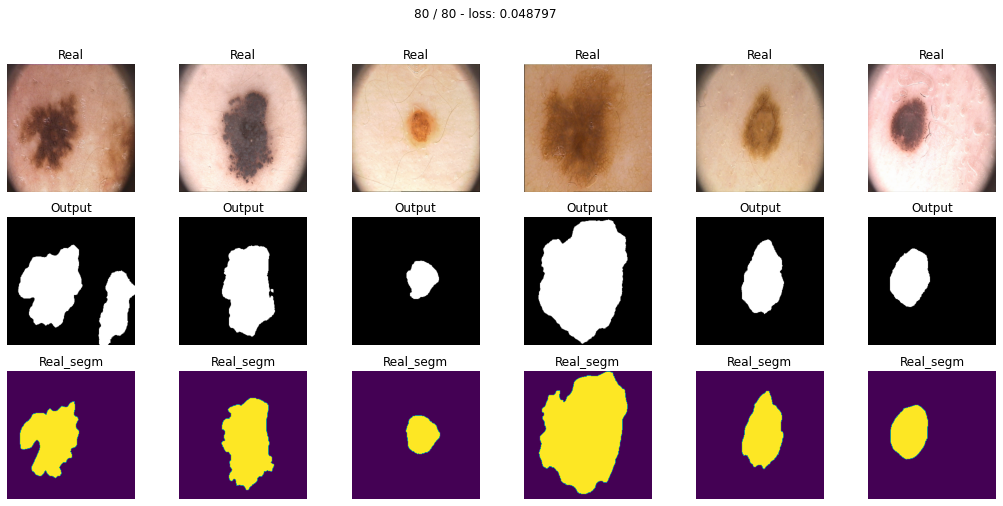

SegNet2 (Tversky loss), IoU score on test data: 0.784
CPU times: user 2min 5s, sys: 25.2 s, total: 2min 30s
Wall time: 2min 30s


In [31]:
%%time
model_tversky = SegNet_2().to(device) # Segnet_2 + tversky_loss

max_epochs = 80
optimaizer = torch.optim.Adam(model_tversky.parameters(), lr=0.001)
train_loss_s2t, val_loss_s2t = train(model_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)
s2t_score = np.round(score_model(model_tversky, iou_pytorch, data_ts), 4)
print("SegNet2 (Tversky loss), IoU score on test data: {}".format(s2t_score))

SegNet2 (Tversky loss), IoU score on test data: 0.784


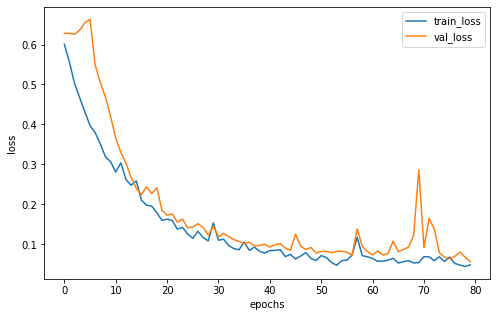

In [32]:
print("SegNet2 (Tversky loss), IoU score on test data: {}".format(s2t_score))
plt.figure(figsize=(8,5))
plt.plot(train_loss_s2t, label="train_loss")
plt.plot(val_loss_s2t, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss");

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

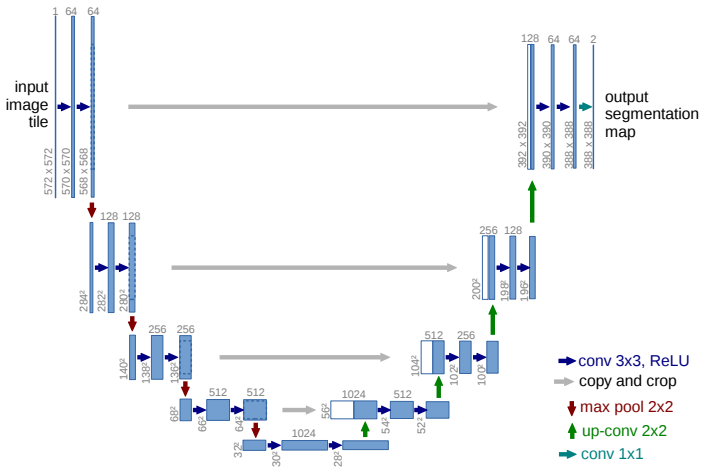

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
# Для ускорения вычислений и снижения частоты проблем с переполнением видеопамяти уменьшено в 2 раза количество фильтров
#  и пропущены 4 сверточных слоя в энкодере. Да и по сути это вообще экспериментальная архитектура на основе вышеуказанной и ванильной U-Net из семинара. 
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.bne0 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(2) # 256 -> 128

        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.bne1 = nn.BatchNorm2d(64)
        self.pool1 =  nn.MaxPool2d(2) # 128 -> 64

        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bne2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2) # 64 -> 32

        self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bne3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv0 = nn.Conv2d(256, 512, 3, padding=1)
        self.bnbn0 = nn.BatchNorm2d(512)
        self.bottleneck_conv1 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnbn1 = nn.BatchNorm2d(512)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bicubic') # 16 -> 32
        self.dec_conv0 = nn.Conv2d(768, 256, 3, padding=1)
        self.bnd0 = nn.BatchNorm2d(256)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bicubic')  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(384, 128, 3, padding=1)
        self.bnd1 = nn.BatchNorm2d(128)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bicubic')  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(192, 64, 3, padding=1)
        self.bnd2 = nn.BatchNorm2d(64)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bicubic')  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(96, 1, 1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bne0(self.enc_conv0(x.cuda()))))
        e1 = self.pool1(F.relu(self.bne1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bne2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bne3(self.enc_conv3(e2))))

        # bottleneck
        b0 = F.relu(self.bnbn0(self.bottleneck_conv0(e3)))
        b1 = F.relu(self.bnbn1(self.bottleneck_conv1(b0)))

        # decoder
        # print(b1.size(), e3.size())
        d0 = F.relu(self.bnd0(self.dec_conv0(self.upsample0(torch.cat((b1, e3), dim=1)))))
        # print(d0.size(), e2.size())
        d1 = F.relu(self.bnd1(self.dec_conv1(self.upsample1(torch.cat((d0, e2), dim=1)))))
        # print(d1.size(), e1.size())
        d2 = F.relu(self.bnd2(self.dec_conv2(self.upsample2(torch.cat((d1, e1), dim=1)))))
        # print(d2.size(), e0.size())
        d3 = self.dec_conv3(self.upsample3(torch.cat((d2, e0), dim=1)))  # no activation
        return d3

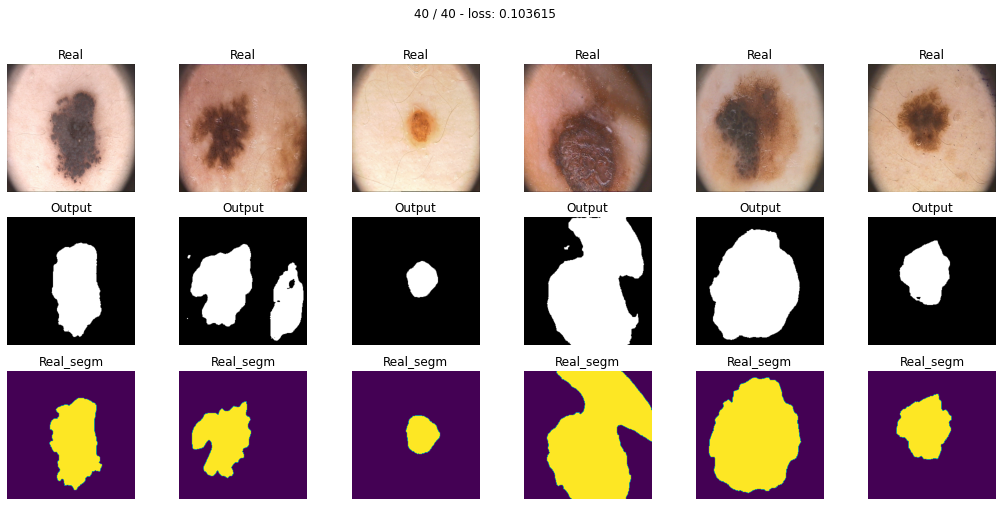

UNet (BCE loss), IoU score on test data: 0.58


In [34]:
unet_model = UNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(unet_model.parameters(), lr=0.001)
train_loss_u, val_loss_u = train(unet_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)
ub_score = np.round(score_model(unet_model, iou_pytorch, data_ts), 4)
print("UNet (BCE loss), IoU score on test data: {}".format(ub_score))

UNet (BCE loss), IoU score on test data: 0.58


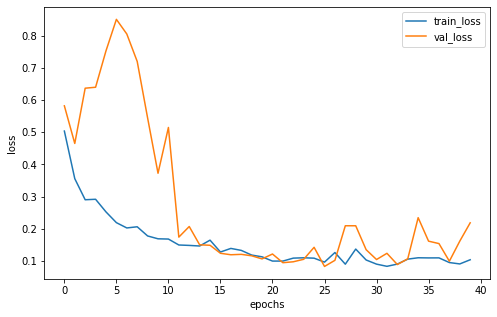

In [35]:
print("UNet (BCE loss), IoU score on test data: {}".format(ub_score))
plt.figure(figsize=(8,5))
plt.plot(train_loss_u, label="train_loss")
plt.plot(val_loss_u, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss");

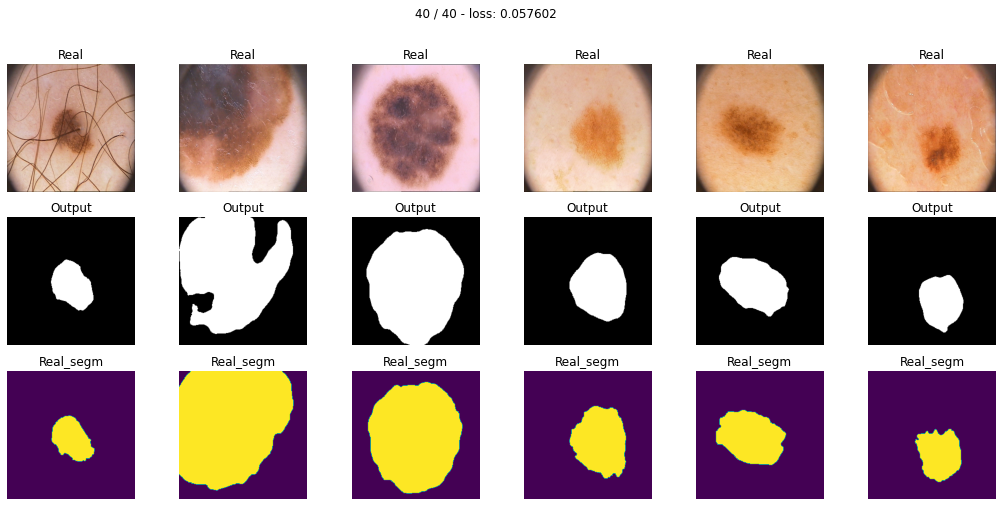

UNet (Tversky loss), IoU score on test data: 0.746


In [36]:
unet_model_t = UNet().to(device) # UNet with Tversky loss
max_epochs = 40
optimaizer = optim.Adam(unet_model_t.parameters(), lr=0.001)
train_loss_ut, val_loss_ut = train(unet_model_t, optimaizer, tversky_loss, max_epochs, data_tr, data_val)
ut_score = np.round(score_model(unet_model_t, iou_pytorch, data_ts), 4)
print("UNet (Tversky loss), IoU score on test data: {}".format(ut_score))

UNet (Tversky loss), IoU score on test data: 0.746


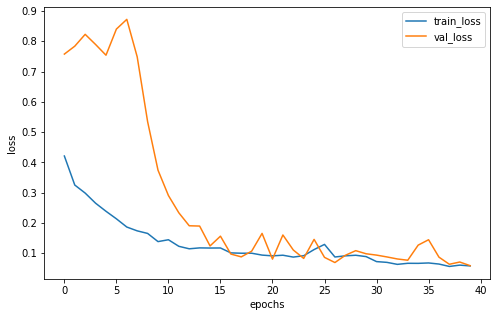

In [37]:
print("UNet (Tversky loss), IoU score on test data: {}".format(ut_score))
plt.figure(figsize=(8,5))
plt.plot(train_loss_ut, label="train_loss")
plt.plot(val_loss_ut, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss");

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.bne0 = nn.BatchNorm2d(32)
        self.pool0 = nn.Conv2d(32, 32, 3, stride=2, padding=1)

        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.bne1 = nn.BatchNorm2d(64)
        self.pool1 =  nn.Conv2d(64, 64, 3, stride=2, padding=1) # 128 -> 64

        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bne2 = nn.BatchNorm2d(128)
        self.pool2 = nn.Conv2d(128, 128, 3, stride=2, padding=1) # 64 -> 32

        self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bne3 = nn.BatchNorm2d(256)
        self.pool3 = nn.Conv2d(256, 256, 3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv0 = nn.Conv2d(256, 512, 3, padding=1)
        self.bnbn0 = nn.BatchNorm2d(512)
        self.bottleneck_conv1 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnbn1 = nn.BatchNorm2d(512)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(768, 768, 2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(768, 256, 3, padding=1)
        self.bnd0 = nn.BatchNorm2d(256)

        self.upsample1 = nn.ConvTranspose2d(384, 384, 2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(384, 128, 3, padding=1)
        self.bnd1 = nn.BatchNorm2d(128)

        self.upsample2 = nn.ConvTranspose2d(192, 192, 2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(192, 64, 3, padding=1)
        self.bnd2 = nn.BatchNorm2d(64)

        self.upsample3 = nn.ConvTranspose2d(96, 96, 2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(96, 1, 1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bne0(self.enc_conv0(x.cuda()))))
        e1 = self.pool1(F.relu(self.bne1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bne2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bne3(self.enc_conv3(e2))))

        # bottleneck
        b0 = F.relu(self.bnbn0(self.bottleneck_conv0(e3)))
        b1 = F.relu(self.bnbn1(self.bottleneck_conv1(b0)))

        # decoder
        d0 = F.relu(self.bnd0(self.dec_conv0(self.upsample0(torch.cat((b1, e3), dim=1)))))
        d1 = F.relu(self.bnd1(self.dec_conv1(self.upsample1(torch.cat((d0, e2), dim=1)))))
        d2 = F.relu(self.bnd2(self.dec_conv2(self.upsample2(torch.cat((d1, e1), dim=1)))))
        d3 = self.dec_conv3(self.upsample3(torch.cat((d2, e0), dim=1)))  # no activation
        return d3

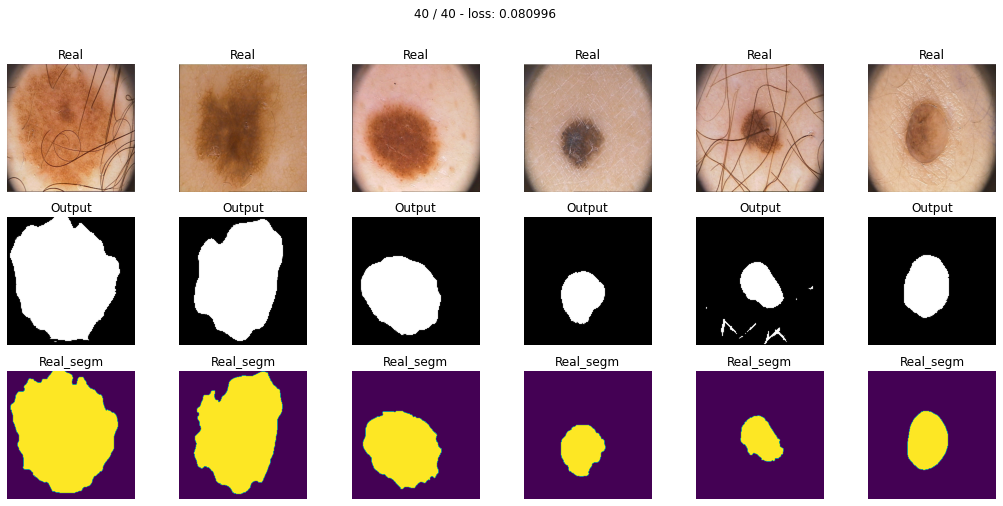

UNet2 (BCE loss), IoU score on test data: 0.722


In [39]:
unet2_model = UNet2().to(device)
max_epochs = 40
optimaizer = optim.Adam(unet2_model.parameters(), lr=0.0001) # для более стабильной работы снижен lr
train_loss_u2, val_loss_u2 = train(unet2_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)
u2b_score = np.round(score_model(unet2_model, iou_pytorch, data_ts), 4)
print("UNet2 (BCE loss), IoU score on test data: {}".format(u2b_score))

UNet2 (BCE loss), IoU score on test data: 0.722


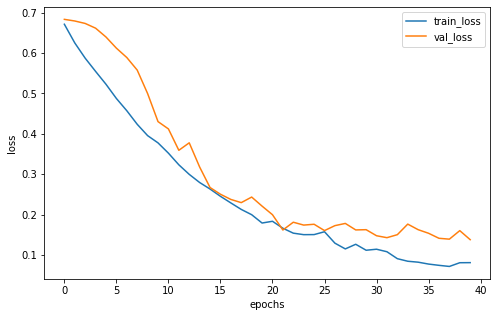

In [40]:
print("UNet2 (BCE loss), IoU score on test data: {}".format(u2b_score))
plt.figure(figsize=(8,5))
plt.plot(train_loss_u2, label="train_loss")
plt.plot(val_loss_u2, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss");

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [0]:
class DilatedSegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=2, dilation=2)
        self.bne0 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=2, dilation=2)
        self.bne1 = nn.BatchNorm2d(64)
        self.pool1 =  nn.MaxPool2d(2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=2, dilation=2)
        self.bne2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=2, dilation=2)
        self.bne3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, 3, padding=1)
        self.bnbn = nn.BatchNorm2d(256)

        # decoder (upsampling)
        self.unpool0 = nn.MaxUnpool2d(2) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(256, 128, 3, padding=2, dilation=2)
        self.bnd0 = nn.BatchNorm2d(128)

        self.unpool1 = nn.MaxUnpool2d(2)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=2, dilation=2)
        self.bnd1 = nn.BatchNorm2d(64)

        self.unpool2 = nn.MaxUnpool2d(2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=2, dilation=2)
        self.bnd2 = nn.BatchNorm2d(32)

        self.unpool3 = nn.MaxUnpool2d(2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(32, 1, 3, padding=2, dilation=2)

    def forward(self, x):
        # encoder
        # print((self.enc_conv0(x.cuda())).size())
        # print((self.pool0(F.relu(self.bne0(self.enc_conv0(x.cuda())))))[0].size())
        e0, pi0 = self.pool0(F.relu(self.bne0(self.enc_conv0(x.cuda()))))
        e1, pi1 = self.pool1(F.relu(self.bne1(self.enc_conv1(e0))))
        e2, pi2 = self.pool2(F.relu(self.bne2(self.enc_conv2(e1))))
        e3, pi3 = self.pool3(F.relu(self.bne3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bnbn(self.bottleneck_conv(e3)))

        # decoder
        d0 = F.relu(self.bnd0(self.dec_conv0(self.unpool0(b, pi3))))
        d1 = F.relu(self.bnd1(self.dec_conv1(self.unpool1(d0, pi2))))
        d2 = F.relu(self.bnd2(self.dec_conv2(self.unpool2(d1, pi1))))
        d3 = self.dec_conv3(self.unpool3(d2, pi0))  # no activation
        return d3

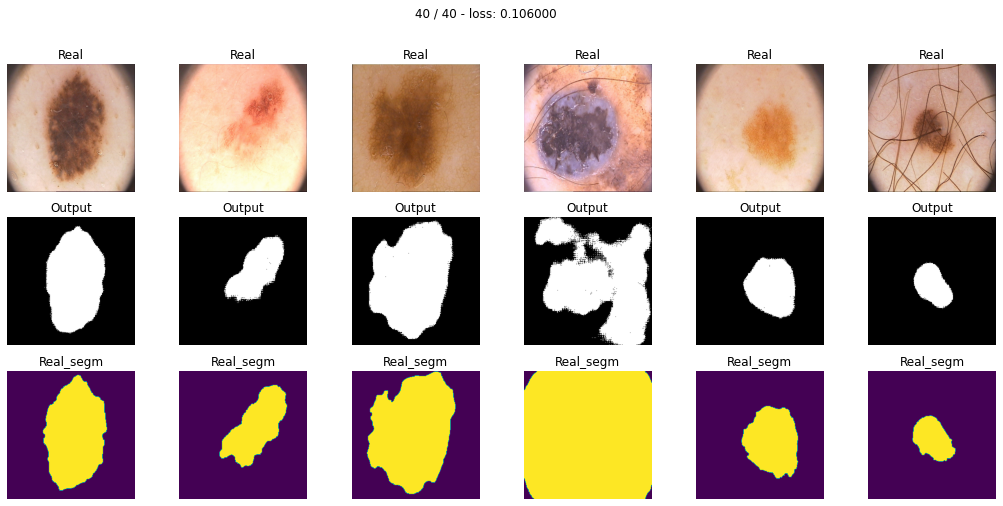

Dilated SegNet (BCE loss), IoU score on test data: 0.676


In [42]:
dilated_model = DilatedSegNet().to(device)
max_epochs = 40
optimaizer = optim.Adam(dilated_model.parameters(), lr=0.001)
train_loss_ds, val_loss_ds = train(dilated_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)
ds_score = np.round(score_model(dilated_model, iou_pytorch, data_ts), 4)
print("Dilated SegNet (BCE loss), IoU score on test data: {}".format(ds_score))

Dilated SegNet (BCE loss), IoU score on test data: 0.676


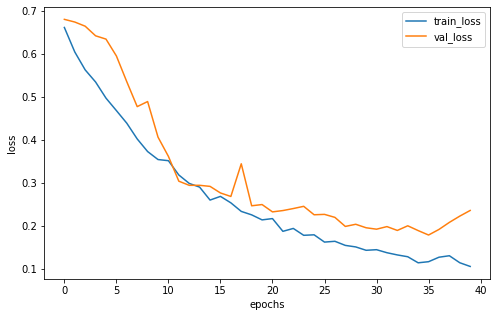

In [43]:
print("Dilated SegNet (BCE loss), IoU score on test data: {}".format(ds_score))
plt.figure(figsize=(8,5))
plt.plot(train_loss_ds, label="train_loss")
plt.plot(val_loss_ds, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss");

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



В данной учебной работе были задействованы две базовых архитектуры нейроных сетей для семантической сегментации: SegNet и UNet. Датасет - снимки поражений кожи ADDI project. В угоду быстродействию и уменьшению проблем, связанных с нехваткой видеопамяти, нейросетевые архитектуры были упрощены как по количеству слоев, так и по количеству параметров. Шедулеры и кроссвалидация не использовались. В качестве оптимайзера везде использовался Adam. Метрика IoU считалась на тестовой выборке. Снимки подавались батчами по 25 штук. Learning rate - 0.001, за исключением UNet2 - 0,0001. Обучение по 40 эпох, за исключеним SegNet2 + Tversky loss (80 эпох в экспериментальных целях).


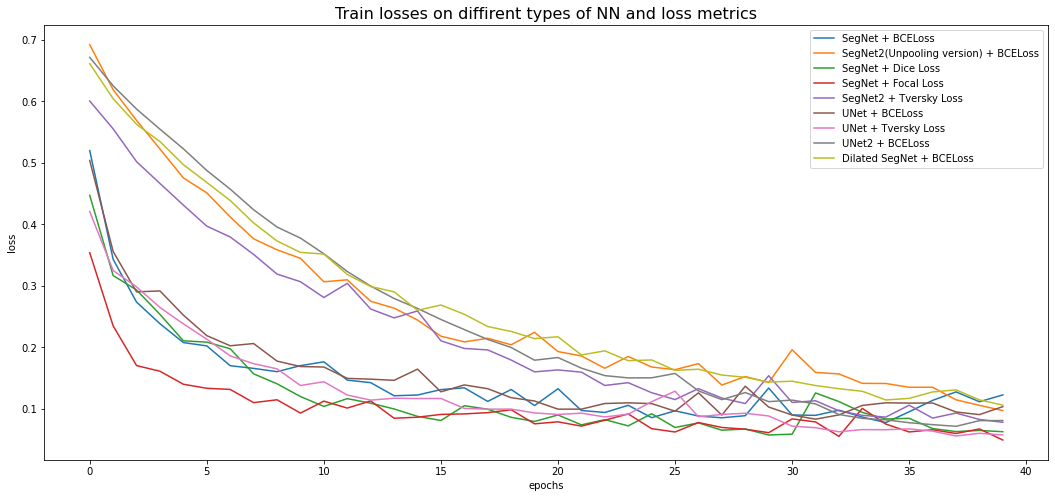

In [44]:
# print("IoU score on test data: {}".format(np.round(score_model(unet2_model, iou_pytorch, data_ts), 4)))
plt.figure(figsize=(18,8))
plt.plot(train_loss_s, label="SegNet + BCELoss")
plt.plot(train_loss_s2, label="SegNet2(Unpooling version) + BCELoss")
plt.plot(train_loss_sd, label="SegNet + Dice Loss")
plt.plot(train_loss_sf, label="SegNet + Focal Loss")
plt.plot(train_loss_s2t[0:40], label="SegNet2 + Tversky Loss")
plt.plot(train_loss_u, label="UNet + BCELoss")
plt.plot(train_loss_ut, label="UNet + Tversky Loss")
plt.plot(train_loss_u2, label="UNet2 + BCELoss")
plt.plot(train_loss_ds, label="Dilated SegNet + BCELoss")
plt.legend()
plt.title("Train losses on diffirent types of NN and loss metrics",  fontsize = 16)
plt.xlabel("epochs")
plt.ylabel("loss");

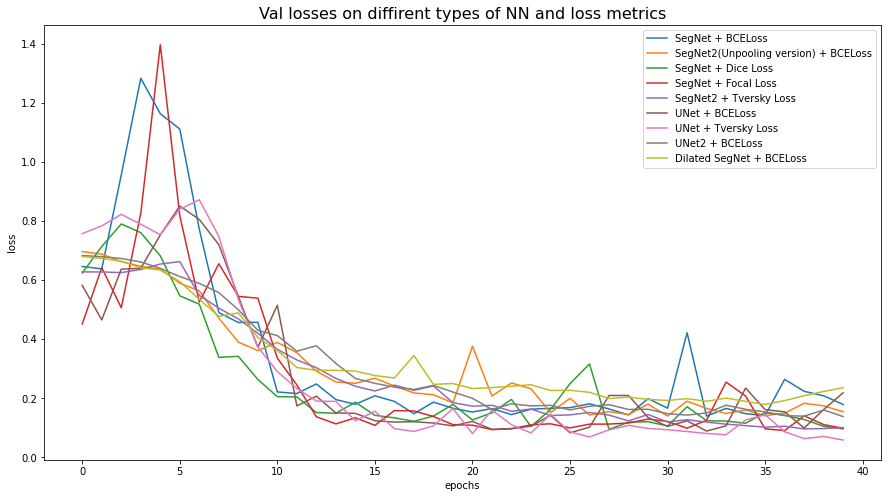

In [45]:
# print("IoU score on test data: {}".format(np.round(score_model(unet2_model, iou_pytorch, data_ts), 4)))
plt.figure(figsize=(15,8))
plt.plot(val_loss_s, label="SegNet + BCELoss")
plt.plot(val_loss_s2, label="SegNet2(Unpooling version) + BCELoss")
plt.plot(val_loss_sd, label="SegNet + Dice Loss")
plt.plot(val_loss_sf, label="SegNet + Focal Loss")
plt.plot(val_loss_s2t[0:40], label="SegNet2 + Tversky Loss")
plt.plot(val_loss_u, label="UNet + BCELoss")
plt.plot(val_loss_ut, label="UNet + Tversky Loss")
plt.plot(val_loss_u2, label="UNet2 + BCELoss")
plt.plot(val_loss_ds, label="Dilated SegNet + BCELoss")
plt.legend()
plt.title("Val losses on diffirent types of NN and loss metrics",  fontsize = 16)
plt.xlabel("epochs")
plt.ylabel("loss");

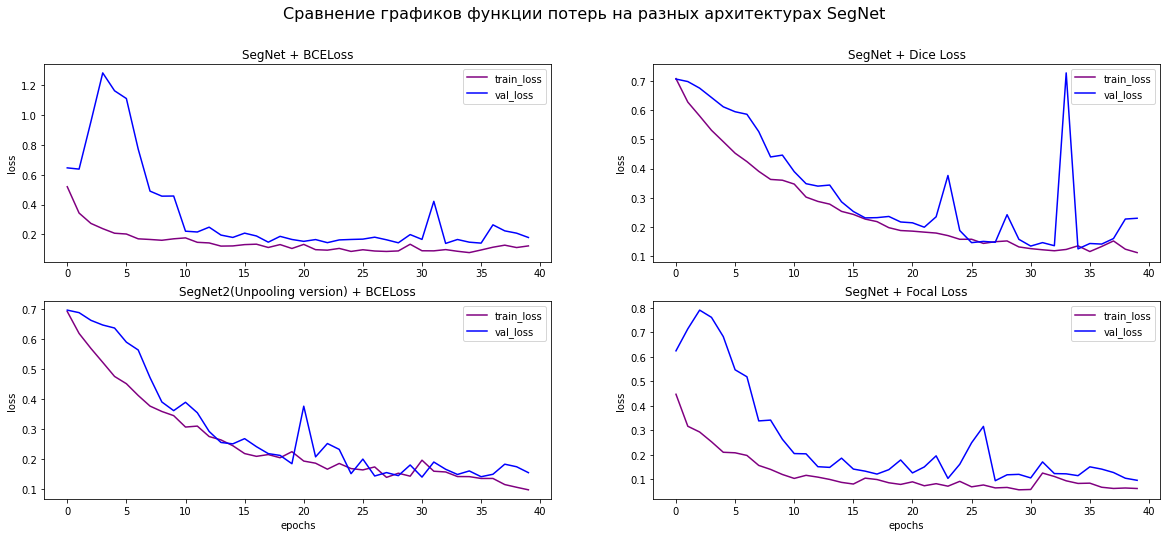

In [46]:
plt.figure(figsize=(20, 8))
plt.suptitle('Сравнение графиков функции потерь на разных архитектурах SegNet', fontsize = 16)
for i in range(1,4,2):
    plt.subplot(2, 2, i)
    plt.plot(losses[i-1][0], label="train_loss", color='purple')
    plt.plot(losses[i-1][1], label="val_loss", color='blue')
    plt.legend()
    plt.ylabel("loss")
    if i == 1:
      plt.title("SegNet + BCELoss")
    else:
      plt.title("SegNet2(Unpooling version) + BCELoss")
      plt.xlabel("epochs");

    plt.subplot(2, 2, i+1)
    plt.plot(losses[i][0], label="train_loss", color='purple')
    plt.plot(losses[i][1], label="val_loss", color='blue')
    plt.legend()
    
    plt.ylabel("loss")
    if i == 1:
      plt.title("SegNet + Dice Loss")
    else:
      plt.title("SegNet + Focal Loss")
      plt.xlabel("epochs");
plt.show();

In [0]:
scores = [sb_score, s2b_score, sd_score, sf_score, s2t_score, ub_score, ut_score, u2b_score, ds_score]
score_labels = ["SegNet + BCELoss", "SegNet2(Unp) + BCELoss", "SegNet + Dice Loss", "SegNet + Focal Loss", "SegNet2 + T Loss", "UNet + BCELoss", "UNet + Tversky Loss", "UNet2 + BCELoss", "Dilated SegNet + BCELoss"]

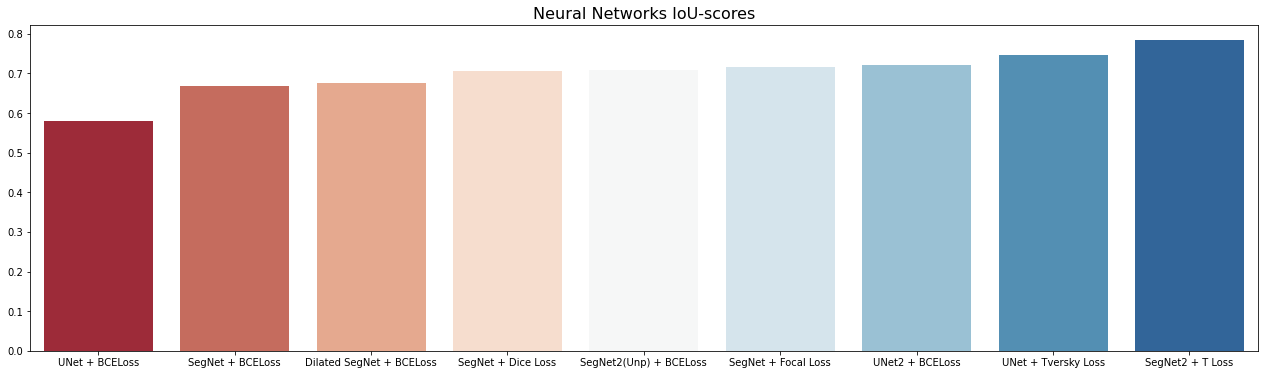

In [48]:
plt.figure(figsize=(22, 6))
sns.barplot(x=sorted(score_labels, key=lambda x: list(np.argsort(scores)).index(score_labels.index(x))), y=sorted(scores), palette='RdBu');
plt.title("Neural Networks IoU-scores", fontdict={'fontsize':16});

  Наилучший результат при прочих равных обычно показывают Segnet2+Tversky loss(что неудивительно, т.к. она училась 80 эпох) и UNet2. Хуже всего повели себя Dilated SegNet + BCE loss и базовые SegNet и UNet + BCE loss. Среди лоссов хорошо показали себя Focal loss и Tversky loss, однако, что касается последнего, то ему, очивидно, требуется больше эпох для обучения. В то время как в районе 40 эпох у других лоссов при заданном learning rate значения на трейне и валидации уже практически не меняются, кривая лоссов при использовании Tversky loss продолжает идти вниз. 
  


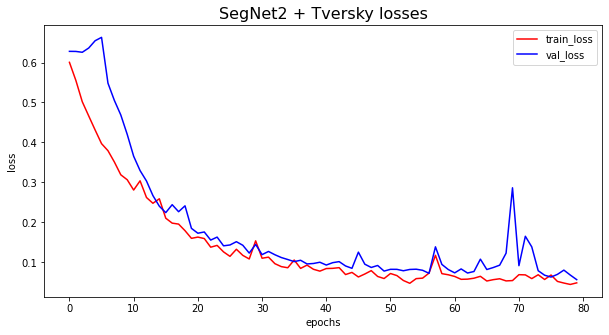

In [49]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_s2t, label="train_loss", color='r')
plt.plot(val_loss_s2t, label="val_loss", color='b')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("SegNet2 + Tversky losses", fontdict={'fontsize':16});

В целом по результатам экспериментов видно, что чем сложнее лосс и архитектура, тем больше требуется эпох, чтобы адекватно обучить модель. На самом деле т.к. мне не удалось добиться полной воспроизводимости результатов, а также учитывая отсутствие оптимизации отдельных параметров для каждой сети, результаты от запуска к запуску различаются достаточно сильно, что не позволяет однозначно определить лучшую архитектуру. Из имеющихся вариантов, я бы продолжил эксперименты с Tversky loss. Некоторые эксперименты со сложными лоссами(например, Focal + Tversky) не принесли хороших результатов. 

  Также хочу отметить, что в зависимости от лосса маска может приобретать либо гладкие, либо рваные края. С увеличением количества эпох и при лучшей оптимизации можно достичь значения IoU более 85%. При данных настройках максимально было получено значение 0,814%.